## About the Dataset

This dataset was recieved from kaggle and it is linked below.

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

##The Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting the batch size and size of images

In [3]:
batch_size = 32
img_height = 218
img_width = 180

In [4]:
data_dir = "/content/drive/MyDrive/brain_tumor_dataset"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=.2,
    subset="training",
    seed=123,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=.2,
    subset="validation",
    seed=123,
    image_size = (img_height,img_width),
    batch_size=batch_size
)


Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


Visaulizing the Data

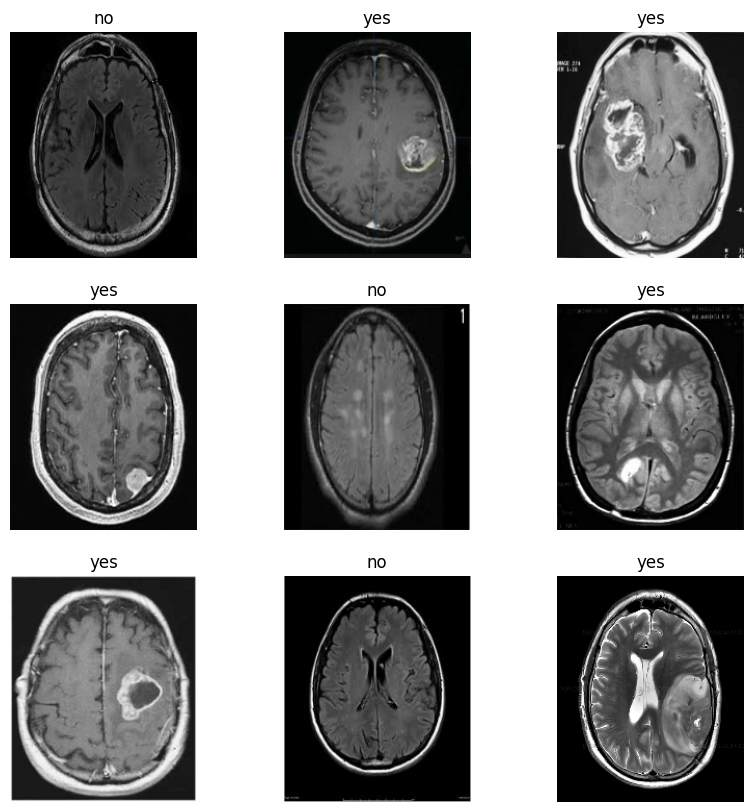

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 218, 180, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 218, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 218, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 90, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 90, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 45, 64)        1

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 18s 2s/step - loss: 0.9872 - accuracy: 0.6453 - val_loss: 0.5795 - val_accuracy: 0.7800
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.4992 - accuracy: 0.7882 - val_loss: 0.6246 - val_accuracy: 0.6000
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.4689 - accuracy: 0.7685 - val_loss: 0.5784 - val_accuracy: 0.7800
Epoch 4/10
7/7 [==============================] - 11s 2s/step - loss: 0.4340 - accuracy: 0.7882 - val_loss: 0.5746 - val_accuracy: 0.8000
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.4222 - accuracy: 0.8276 - val_loss: 0.5247 - val_accuracy: 0.8400
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.3476 - accuracy: 0.8571 - val_loss: 0.5435 - val_accuracy: 0.8600
Epoch 7/10
7/7 [==============================] - 12s 2s/step - loss: 0.2670 - accuracy: 0.9015 - val_loss: 0.5817 - val_accuracy: 0.8400
Epoch 8/10
7/7 [======================

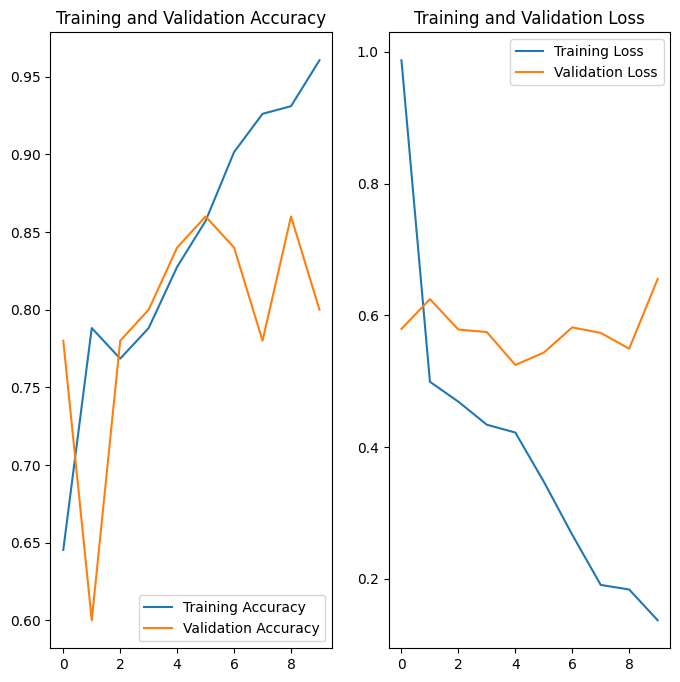

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The Validation Accuracy is only around 80%, but I think that I can improve the model because it appears the model is overfitted because of the increasing linearity of the training accuracy

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

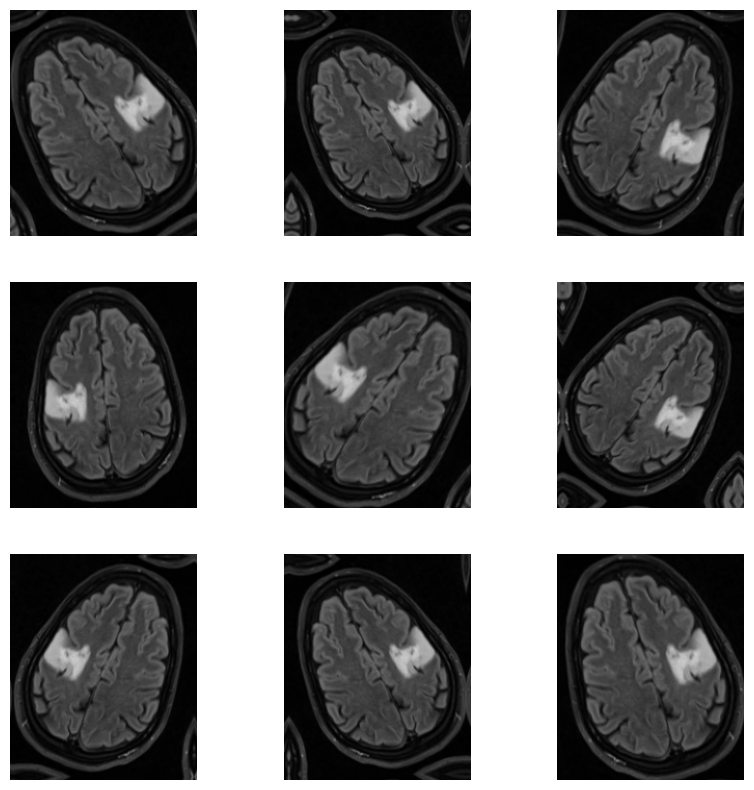

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 218, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 218, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 218, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 109, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 90, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 45, 32)        0         
 g2D)                                                 

In [19]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/25
7/7 [==============================] - 13s 2s/step - loss: 0.9833 - accuracy: 0.5813 - val_loss: 0.5885 - val_accuracy: 0.7000
Epoch 2/25
7/7 [==============================] - 12s 2s/step - loss: 0.6182 - accuracy: 0.6897 - val_loss: 0.5807 - val_accuracy: 0.7600
Epoch 3/25
7/7 [==============================] - 11s 1s/step - loss: 0.5660 - accuracy: 0.7438 - val_loss: 0.5599 - val_accuracy: 0.7800
Epoch 4/25
7/7 [==============================] - 12s 2s/step - loss: 0.5624 - accuracy: 0.7389 - val_loss: 0.5959 - val_accuracy: 0.7800
Epoch 5/25
7/7 [==============================] - 10s 1s/step - loss: 0.5255 - accuracy: 0.7537 - val_loss: 0.5155 - val_accuracy: 0.8000
Epoch 6/25
7/7 [==============================] - 11s 1s/step - loss: 0.5115 - accuracy: 0.7389 - val_loss: 0.5260 - val_accuracy: 0.8200
Epoch 7/25
7/7 [==============================] - 15s 2s/step - loss: 0.4877 - accuracy: 0.7635 - val_loss: 0.5855 - val_accuracy: 0.7800
Epoch 8/25
7/7 [==================

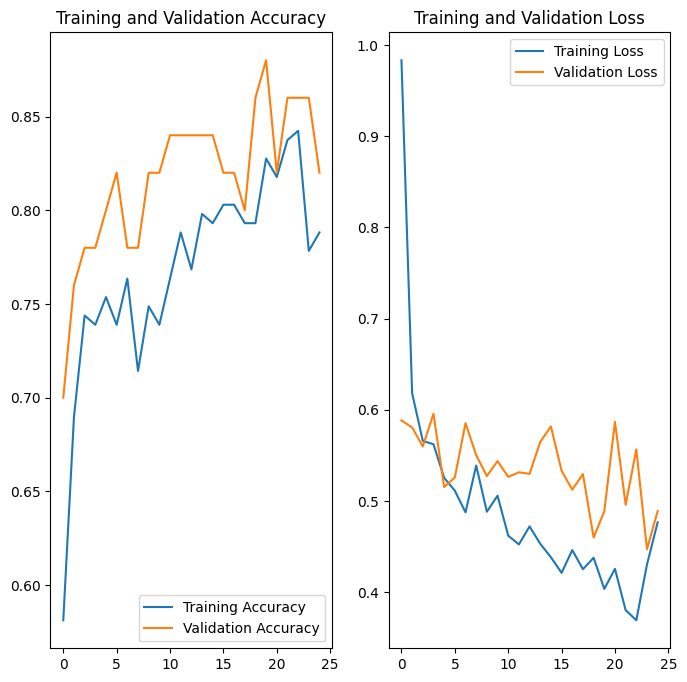

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This is less overfitted because the training accuarcy and the val accuarcy are similar

In [21]:
normal_scan_path ="/content/drive/MyDrive/Brain_Tumor_Testing/No_Image.jpeg"

img = tf.keras.utils.load_img(
    normal_scan_path, target_size =(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img) # Makes the image into an array so it can be used for prediction
img_array = tf.expand_dims(img_array, 0 ) # This creates a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 174ms/step
This image most likely belongs to no with a 73.13 percent confidence.


In [22]:
normal_scan_path ="/content/drive/MyDrive/Brain_Tumor_Testing/Yes_Image.webp"

img = tf.keras.utils.load_img(
    normal_scan_path, target_size =(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img) # Makes the image into an array so it can be used for prediction
img_array = tf.expand_dims(img_array, 0 ) # This creates a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to yes with a 94.65 percent confidence.


In [23]:
normal_scan_path ="/content/drive/MyDrive/Brain_Tumor_Testing/Yes_2.jpeg"

img = tf.keras.utils.load_img(
    normal_scan_path, target_size =(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img) # Makes the image into an array so it can be used for prediction
img_array = tf.expand_dims(img_array, 0 ) # This creates a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 38ms/step
This image most likely belongs to yes with a 76.26 percent confidence.


##Summary

###Data Preproccesing

There was not a lot of data preproccessing that needed to be done, besides splitting the dataset into a training and testing sets. After implementing the model once, the model was very overfitted so data augmentation was added to create more variance in the model to reduce overfitting.

###The Model

The model that was used was a convolutional neutral network which is the standard model used for image classification. The model has 3 convolutional layers which all were followed by max pooling. Then were was a dropout layer which was followed by flattening to get the final result. After the data augmentation was done, the model had a validation accuary of 84%. The model was tested on 3 different images which all were classified correctly.